In [357]:

import numpy as np
import deepchem as dc
import numpy as np
import torch
from pysmiles import read_smiles
import networkx as nx
import dgllife
from rdkit import Chem
import random
import spektral
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import dgl
from dgl import DGLGraph
from torch.nn.utils.rnn import pad_sequence


import pandas
import csv
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
%run MoleculeGenerator2.ipynb
%run Discrim.ipynb



In [3]:
drugs = pandas.read_csv('SmallDrug.csv',error_bad_lines=False,delimiter=';')
smiles_values = drugs['Smiles'].values
graphs = smiles_to_graph(smiles_values[:30])

# max_nodes = 12
# num_atom_types = 14
# num_node_feats = 34
# num_edge_types = 3
# bond_padding = 12
# env = GraphGenEnv(max_nodes,num_atom_types,num_node_feats,num_edge_types,bond_padding)
# PPO_agent = PPO(env)

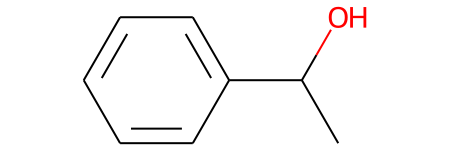

In [218]:
batch = dgl.load_graphs('./graph_decomp/chunk_4')


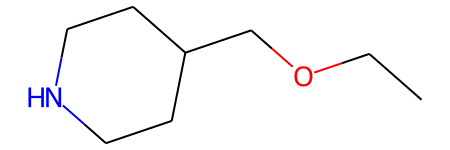

In [240]:
MolFromGraphsAro(batch[0][230])

In [285]:
l = list(zip([1,2,3],[5,7,9],[3,1,2]))
a,b,c = zip(*l)
a,b,c

((1, 2, 3), (5, 7, 9), (3, 1, 2))

In [387]:
class Supervised_Training_Wrapper:
    '''wrapper for supervised pretraining of the model'''
    def __init__(self, input_dim, path):
        self.path = path        
        
        self.policy = Spin3(input_dim,300,14)
        self.optim = Adam(self.policy.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.smiles_values = pandas.read_csv(path,error_bad_lines=False,delimiter=';')['Smiles'].values
        self.vals = 0
        
        self.chunk_idx = 0
        
    def process_data_batch(self, batch_size):
        random.shuffle(self.smiles_values)
        return data_base_generator_small(self.smiles_values,batch_size)
    
    def pull_batch(self,num_chunks):
        path = './graph_decomp/chunk_1'
        batch = dgl.load_graphs(path)
        
        return batch[0][:300], batch[1]['last_action'][:300], batch[1]['actions'][:300]
        if self.chunk_idx >= num_chunks:
            self.chunk_idx = 0
            
        path = './graph_decomp/chunk_' + str(self.chunk_idx)
        batch = dgl.load_graphs(path)
        
        return batch[0], batch[1]['last_action'], batch[1]['actions']
    
    
    def train_on_chunk(self,batch_size,num_chunks):
        graphs,last_action_nodes, targets = self.pull_batch(num_chunks)        
        
        temp = list(zip(graphs, last_action_nodes,targets))
        random.shuffle(temp)
        
        graphs,last_action_nodes, targets = zip(*temp)
        graphs,last_action_nodes, targets = list(graphs), torch.Tensor(last_action_nodes),torch.Tensor(targets)
                
        i = batch_size
        
        while i < len(graphs):
            graphs_batch = graphs[i-batch_size:i]
            last_actions_batch = last_action_nodes[i-batch_size:i]
            targets_batch = targets[i-batch_size:i]
            

            loss = self.train_on_batch(graphs_batch,last_actions_batch,targets_batch)            
            
            i += batch_size
            print(loss)
            
            
    
    def train_on_batch(self,graphs,last_action_nodes,actions):
        last_action_nodes = torch.unsqueeze(last_action_nodes,dim =1)        
        pred = self.policy.forward(dgl.batch(graphs), last_action_nodes, softmax = False)        


        #print(pred[0])
        
        loss = self.loss_fn(pred,actions.long())
        
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        
        return loss.detach()
    
    def train(self,batch_size,num_chunks,num_epochs):
        for epoch in range(num_epochs):
            self.train_on_chunk(batch_size,num_chunks)
        
            

In [388]:
sup_train = Supervised_Training_Wrapper(34,'./SmallDrug.csv')

In [389]:
path = './graph_decomp/chunk_1'
batch = dgl.load_graphs(path)

In [390]:
sup_train.train(128,19,35)
print('fra')

tensor(4.6571)
tensor(4.7447)
tensor(4.6208)
tensor(4.7434)
tensor(4.5188)
tensor(4.6685)
tensor(4.4842)
tensor(4.5007)
tensor(4.2818)
tensor(4.4622)
tensor(4.2661)
tensor(3.9867)
tensor(3.8536)
tensor(3.8028)
tensor(3.6703)
tensor(3.5998)
tensor(3.3162)
tensor(3.5130)
tensor(3.3380)
tensor(3.3983)
tensor(3.1793)
tensor(3.1497)
tensor(3.1063)
tensor(3.2195)
tensor(2.9300)
tensor(3.3072)
tensor(3.0819)
tensor(3.0681)
tensor(2.9767)
tensor(2.9860)
tensor(3.0529)
tensor(2.9054)
tensor(2.9642)
tensor(2.9828)
tensor(2.9539)
tensor(2.7796)
tensor(2.6694)
tensor(2.9959)
tensor(2.9668)
tensor(2.7888)
tensor(3.0347)
tensor(2.6890)
tensor(2.6625)
tensor(2.7691)
tensor(2.7649)
tensor(2.5828)
tensor(2.7383)
tensor(2.7891)
tensor(2.6971)
tensor(2.7163)
tensor(2.7603)
tensor(2.5018)
tensor(2.5935)
tensor(2.6816)
tensor(2.5201)
tensor(2.7671)
tensor(2.5816)
tensor(2.5182)
tensor(2.5607)
tensor(2.6374)
tensor(2.4374)
tensor(2.6200)
tensor(2.5739)
tensor(2.4484)
tensor(2.7358)
tensor(2.2261)
tensor(2.5

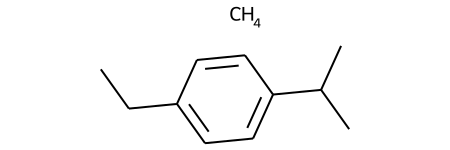

In [281]:
MolFromGraphsAro(batch[0][6])

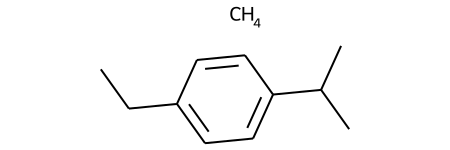

In [325]:
MolFromGraphsAro(batch[0][i])

In [396]:
i = 105
batch[0][i],batch[1]['last_action'][i],batch[1]['actions'][i]

(Graph(num_nodes=9, num_edges=27,
       ndata_schemes={'atomic': Scheme(shape=(34,), dtype=torch.float32)}
       edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)}),
 tensor(0.),
 tensor(169.))

In [427]:
l1 = [int(x) for x in list(batch[1]['actions'])]

In [432]:
bins = {'terminate' : 0, 'add_node' :0, 'add_edge':0}
for action in l1:
    if action == 0:
        bins['terminate'] +=1
    if action in range(1,15):
        bins['add_node'] +=1
    else:
        bins['add_edge'] +=1
    

In [434]:
3734/(3734+4529+501)

0.42606115928799637

In [422]:
l2 = [int(x) for x in list(batch[1]['last_action'])]

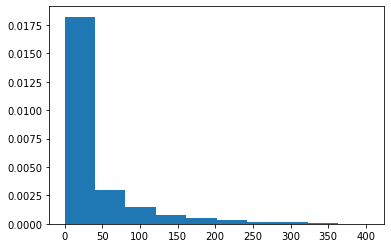

In [426]:
len(batch[1]['actions'])
plt.hist(l1, density=True, bins = 10)
plt.show()

In [395]:
i = 105
torch.softmax(sup_train.policy.forward(batch[0][i],batch[1]['last_action'][i]),dim=1)#[0,173]

tensor([[0.0063, 0.0059, 0.0088, 0.0065, 0.0057, 0.0056, 0.0057, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0057, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056,
         0.0056, 0.0056, 0.0

In [282]:
sup_train.train(24,19,10)

TypeError: unsqueeze(): argument 'input' (position 1) must be Tensor, not tuple

In [210]:
def data_base_generator_small(smiles,chunk_size):
    '''function for generating decomp trajectories on the fly for immediate consumption
       More for testing overfitting
    '''
    
    graphs = []
    last_action_nodes = []
    actions = []
    
    for i in range(chunk_size):
        smile = smiles[i]
        if mol_checker(smile,'SMILES'):
            graph = smiles_to_graph([smile])[0]
            graphs_single,last_action_nodes_single, actions_single = full_graph_decomp(graph)
            
            graphs.extend(graphs_single)
            last_action_nodes.extend(last_action_nodes_single)
            actions.extend(actions_single)
    return graphs,last_action_nodes,actions
        


In [205]:
mol = Chem.MolFromSmiles(smiles_values[1])

In [211]:
len(smiles_values)

38683

In [214]:
def data_base_generator(smiles,chunk_size, path):
    '''function for generating and storing decomposition trajectories'''
    i = chunk_size 
    j=0
    while i < len(smiles):
        graphs = []
        last_action_nodes = []
        actions = []
        smiles_chunk = smiles[i-chunk_size: i]
        
        for smile in smiles_chunk:
            if mol_checker(smile,'SMILES'):
                graph = smiles_to_graph([smile])[0]
                graphs_single,last_action_nodes_single, actions_single = full_graph_decomp(graph)
                
                graphs.extend(graphs_single)
                last_action_nodes.extend(last_action_nodes_single)
                actions.extend(actions_single)
        print(torch.tensor(last_action_nodes).shape)
        print(torch.tensor(actions).shape)
        
        graph_labels = {"last_action" : torch.tensor(last_action_nodes), 
                        "actions" : torch.tensor(actions)}
        
    
        dgl.save_graphs('./graph_decomp/chunk_' + str(j),graphs, graph_labels)
        j+=1
        i+= chunk_size
        print(i)
    
    
    

In [215]:
data_gen = data_base_generator(smiles_values,1000,'./graph_decomp2')

fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart


fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
torch.Size([8690])
torch.Size([8690])
6000
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
f

fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fa

fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fa

fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
torch.Size([8441])
torch.Size([8441])
19000
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
decomp error
decomp error
fart
fart
fart
fart
fart
fart
fart
fart
fart
fart
f

KeyboardInterrupt: 

In [198]:
def full_graph_decomp(graph):
    '''final function for generating a single graph trajectory '''
    
    graphs = [graph.clone()]
    last_action_nodes = [torch.zeros(1)]
    actions = [torch.zeros(1)]
    finish = False
    
    g_clone = graph.clone()
    
    while not finish:
        a = graph_decomp_step2(g_clone)
        
        graph_r,last_action_node,action,finish = a
        if not finish:
            graphs.append(graph_r)
            last_action_nodes.append(last_action_node)
            actions.append(action)
    return graphs[:],last_action_nodes[:],actions[:]
        

In [195]:
def graph_decomp_step2(graph):
    '''
    Take 2
    First: check if we're at 2nodes and edge or at 6
    Second: attempt node removal
    Third: attempt ring disconnect
    
    returns (graph, action, finished)
    '''
    
    last_action_node = torch.zeros((1,1))
    
    mol = MolFromGraphsAro(graph)
    action = -1
    found = False
    
    if graph.num_nodes() == 2 or (graph.num_nodes() == 6 and 
                                  [atom.GetSymbol() for atom in mol.GetAromaticAtoms()] == 
                                  ['C', 'C', 'C', 'C', 'C', 'C']):
        return (graph,last_action_node, -1, True)
    
    #case for disconnected graph
    elif not nx.is_connected(graph.to_networkx().to_undirected()):
        last_action_node = torch.ones((1,1))
        found = True
        graph,action, found = remove_node(graph)
        if not found:
            graph,action,found = remove_single_ring(graph)
        
    elif not found:
        graph,action,found = remove_ring_edge(graph)
        
    if not found:
        graph,action,found = remove_leaf_edge(graph)
   
    if found:
        graph = update_graph(graph)
        return graph,torch.tensor(1-int(nx.is_connected(graph.to_networkx().to_undirected()))),action,False
    
    if not found:
        node_idx_s = list(range(graph.num_nodes()))
        random.shuffle(node_idx_s)
        for idx in node_idx_s:
            graph,action, found = remove_edge_from_node(graph,idx)
            if found:
                print("fart")
                try:
                    graph = update_graph(graph)
                except:
                    MolFromGraphsAro(graph)
                    return(graph,torch.tensor(1-int(nx.is_connected(graph.to_networkx().to_undirected()))),action,False)
                return(graph,torch.tensor(1-int(nx.is_connected(graph.to_networkx().to_undirected()))),action,False)
            
    print("decomp error")
    return(smiles_to_graph(['C-C'])[0],0,torch.Tensor(2),True)
           

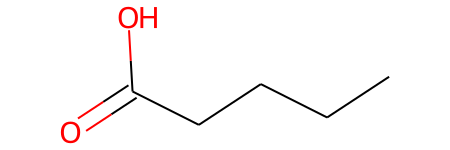

In [59]:
grp = batch[0][0].clone()
1- int(nx.is_connected(grp.to_networkx().to_undirected()))


0

In [78]:
def remove_single_ring(graph):
    mol = MolFromGraphsAro(graph)
    found = False
    node_id = -1
    
    if sum([atom.GetDegree() for atom in mol.GetAromaticAtoms()]) == 12:
        found = True
        graph.remove_nodes([atom.GetIdx() for atom in mol.GetAromaticAtoms()])
        node_id = torch.Tensor([13])
    return(graph,node_id,found)

In [79]:
def remove_ring_edge(graph):
    found = False
    node_idx,found_incident_id,edge_type = -1,-1,-1
    action = -1
    mol = MolFromGraphsAro(graph)
    aro_ring_atoms = [atom.GetIdx() for atom in mol.GetAromaticAtoms()]
    if [atom.GetSymbol() for atom in mol.GetAromaticAtoms()] == ['C', 'C', 'C', 'C', 'C', 'C']:
        atom_degrees = [(atom.GetIdx(),atom.GetDegree()) for atom in mol.GetAromaticAtoms()]
        total = sum(int(degree) for idx,degree in atom_degrees)
        if total == 13:
            found = True
            for (idx,degree) in atom_degrees:
                if degree == 3:
                    connection_atom_idx = idx
                    break
            else:
                print('oopah!')
            _,(action),_ = remove_edge_from_node(graph,connection_atom_idx,suppress_connection=True)
    return(graph,action,found)
     
    

In [80]:
def remove_leaf_edge(graph):
    found = False
    action = -1
    
    
    adj = graph.adj().to_dense()
    adj_sum_1d = torch.sum(adj, dim = 0) == 2
    idx_s = adj_sum_1d.nonzero().flatten()
    
    node_idx,found_incident_id,edge_type = -1,-1,-1
    
    if idx_s.shape[0]>0:
        single_node = int(random.choice(idx_s))
        _,action,_ = remove_edge_from_node(graph, single_node, suppress_connection=True)
        found = True
    
    return graph,action,found 
        

In [81]:
def remove_edge_from_node(graph,node_idx,suppress_connection = False):
    '''
    function for removing a single edge
    from the graph. 
    
    need last tensor as well as edge type 
    
    convert to networkx to check that we dont 
    accidentally make a disconnected graph
    
    this will have to be revised for aromatic rings/
    other issues.
    
    returns: (mutated_graph, idx of correct node to detach from or -1 if there is)
    '''    
    edges = graph.in_edges(node_idx,'all')
    in_edges = edges[0]
    edge_ids = edges[2]
    
    found = False
    i = 0
    graph_clone = graph
    found_incident_id = -1
    edge_type = -1

    while (not found and i < in_edges.shape[0]):
        if (in_edges[i] != node_idx) and (graph.edata['type'][edge_ids[i]] != 3):
            
            graph_clone = graph.clone()
            incident_id = in_edges[i]
            graph_clone.remove_edges(graph.edge_ids([node_idx,incident_id],[incident_id,node_idx]))
            network = graph_clone.to_networkx()
            if (suppress_connection or nx.is_connected(network.to_undirected())):
                edge_type = graph.edata['type'][edge_ids[i]]
                found = True
                found_incident_id = incident_id
                graph.remove_edges(graph.edge_ids([node_idx,incident_id],[incident_id,node_idx]))
        
        else:
            pass
        i += 1
        
        if found:
            action = 2*(node_idx*graph.num_nodes() + found_incident_id) + edge_type - 1
        else:
            #print('NOTFOUND?')
            action = -1
            
        
    return graph_clone, action+15, found   
    #return (graph_clone,(node_idx,int(found_incident_id),int(edge_type)),found)
        
    
    

In [82]:
def remove_node(graph):
    '''
    funcntion for removing a single node of 
    degree 1 (2 w self loops) from a graph
    
    returns: (mutated_graph, type of removed node, incident node)
    '''
    
    atom_list = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K']
    
    adj = graph.adj().to_dense()
    adj_sum_1d = torch.sum(adj, dim = 0) == 1
    idx_s = adj_sum_1d.nonzero().flatten()
    
    atom_type_slice = -1
    
    if idx_s.shape[0]>0:
        
        choice_id = random.randint(0,idx_s.shape[0]-1)
        choice = idx_s[choice_id]

        adj[choice][choice] = 0     
        incident_node = (adj[choice] == 1).nonzero()

        tensor = graph.ndata['atomic'][choice]
        
        atom_type_slice = tensor[12:26].nonzero()[0][0]
        
        
        graph.remove_nodes(choice.int())
        success = True
        atom_type = 'n'#Mosdf(tensor)
    else:
        atom_type='null'
        success= False
    
    
    return (graph,torch.tensor([atom_type_slice+1]), success)
    
    

In [83]:
class GraphGenEnv(object):
    '''
    Class which holds logic for graph generation environment 
    Observations come in the form of (current_graph, last action was node addition, last node features)
    
    
    '''
    def __init__(self, max_nodes, num_atom_types, num_node_feats, num_edge_types, bond_padding, batch_dim = 1):
        '''
        ENV_Atoms
        '''
        
        self.atom_list = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K', 'Aro']
        self.atom_bond_dict = {'N':[1,0,5], 'C':[2,0,4], 'O':[3,0,6], 'S':[4,0,6],
                               'F':[5,0,7], 'Cl' : [6,0,7],'Na':[7,0,7], 'P' : [8,0,5],
                               'Br':[9,0,7], 'Si' : [10,0,4],'B':[11,0,3], 'Se' : [12,0,6],
                               'K':[13,0,7]}
        
        '''
        ENV_Attributes
        '''
        self.max_nodes = max_nodes
        self.bond_padding = bond_padding 
        self.num_atom_types = self.atom_list.__len__()
        self.batch_dim = 1
        
        
        self.stateSpaceGraph = dgl.graph(([], []))
        self.stateSpaceGraph.ndata['atomic'] = torch.zeros(0, num_node_feats)
        self.stateSpaceGraph.edata['type'] = torch.zeros(0,1)
        
        
        
        '''ENV_State'''
        self.Done = False
        self.last_action_node = torch.zeros((1,1))
        self.num_node_feats = num_node_feats
        self.last_atom_features = torch.zeros(1,self.num_node_feats)
        self.reward = 0
        self.just_added_node = False
        
        self.log = ""
        
        self.completed_mols = []
        
        
        '''
        External_Rewards
        '''
        self.model_list = []
        self.CHEMBL_PROBS ={'C': 0.6898629450595509,
         'O': 0.1332442465198711,
         'N': 0.13833186968596936,
         'S': 0.014837421245950432,
         'F': 0.006966554775322327,
         'Cl': 0.00867552920173583,
         'Na': 0.000823191628176471,
         'P': 0.0016789827267325664,
         'Br': 0.0008892252913808997,
         'Si': 0.00020213282124829636,
         'B': 0.0006702187823777577,
         'Se': 0.00021699605734634353,
         'K': 0.00018073128548035922}
        
        
        
    def __len__(self):
        return self.stateSpaceGraph.number_of_nodes()
    
    @property
    def n_nodes(self):
        return self.stateSpaceGraph.number_of_nodes()
    
    def set_models(self,models):
        self.model_list = models
        
    def twoNodesOneEdge(self):

        self.addNode(self.atom_list[1],give_reward = False)
        self.last_action_node = (self.batch_dim,1) 
        self.just_added_node = False
        self.addNode(self.atom_list[1],give_reward = False)
        atom_id = 0
        edgeType = 1
        self.addEdge(edgeType,atom_id,give_reward = False)

#         self.addNode(self.atom_list[np.random.randint(0,4)],give_reward = False)
#         self.last_action_node = (self.batch_dim,1) 
#         self.just_added_node = False
#         self.addNode(self.atom_list[np.random.randint(0,4)],give_reward = False)
#         atom_id = 0
#         edgeType = np.random.randint(1,3)
#         self.addEdge(edgeType,atom_id,give_reward = False)
          
            
    def reset(self):        
        self.just_added_node = False
        self.reward = 0
        self.log = ""
        
        
        self.last_action_node = torch.zeros((self.batch_dim,1))
        self.stateSpaceGraph = dgl.graph(([], []))
        self.stateSpaceGraph.ndata['atomic'] = torch.zeros(0, self.num_node_feats)
        self.stateSpaceGraph.edata['type'] = torch.zeros(0,1)
        
        
        
        x = np.random.randint(0,5)
        if x>1:   
            self.twoNodesOneEdge()
        else:
            self.addAromaticRing()
        
        
        
        self.Done = False
        self.last_atom_features = torch.zeros(1, self.num_node_feats)
        
        self.stateSpaceGraph = selfLoop(self.stateSpaceGraph)
        return self.stateSpaceGraph, self.last_action_node, self.last_atom_features
    
    def oneHot(self,number, max_size, index):
        OneHot = np.zeros(max_size)
        OneHot[number-index] = 1
        return OneHot
    
    def draw(self):
        network = self.stateSpaceGraph.to_networkx()
        nx.draw(network)
        
    
    
    def addAromaticRing(self):        
        curr_num_nodes = self.n_nodes

        atom_type, degree, valence = self.atom_bond_dict['C']     

        atom_type_onehot = self.oneHot(atom_type,self.num_atom_types,1)

        #automatically put at 3 as this is the number for aromatic bonds
        degree = self.oneHot(3,self.bond_padding,0)
        valence_onehot = self.oneHot(valence,8,1)

        feats = torch.tensor(np.concatenate((degree, atom_type_onehot,valence_onehot))).float()

        for i in range(6):
            self.stateSpaceGraph.add_nodes(1)
            self.stateSpaceGraph.ndata['atomic'][-1] = feats
  
        for i in range(6):

            j = i+curr_num_nodes
            self.stateSpaceGraph.add_edges([curr_num_nodes+i,curr_num_nodes+((i+1)%6)],[curr_num_nodes+((i+1)%6),curr_num_nodes+i], {'type': torch.tensor([[3], [3]],dtype=torch.float)})
            self.stateSpaceGraph.edata['type'][-1]

        self.last_atom_features = torch.unsqueeze(feats, dim = 0)
    
    def addNode(self, node_choice, give_reward = True):        
        if self.last_action_node == 1:
            if give_reward:
                self.reward -= .1
        else:
            if give_reward:
                self.reward+=.1
                
            
                
            temp_last_action = self.last_action_node
            self.last_action_node = torch.ones((self.batch_dim,1))
            
            if node_choice == 'Aro':
                self.addAromaticRing()
            else:
                '''
                featurize node correctly before adding it in
                atom features are [atom1,atom2,atom3,atom4,]

                '''

                atom_type, degree, valence = self.atom_bond_dict[node_choice]     
                atom_type_onehot = self.oneHot(atom_type,self.num_atom_types,1)
                #print(atom_type_onehot)
                '''
                pad here for mistakes
                '''
                degree = self.oneHot(0,self.bond_padding,0)
                valence_onehot = self.oneHot(valence,8,1)
                
                #print(degree.shape,atom_type_onehot.shape,valence_onehot.shape)
                feats = torch.tensor(np.concatenate((degree, atom_type_onehot,valence_onehot))).float()


                self.stateSpaceGraph.add_nodes(1)
                self.stateSpaceGraph.ndata['atomic'][-1] = feats
                self.last_atom_features = torch.unsqueeze(feats, dim = 0)

                
    def degreeAddition(self, atom_features,edge_type ,start = 0, stop = None):
        '''
        Method for calculating the new node features resulting from adding a new edge to the graph
        takes current features of the atom, the type of bond, i.e. 1 or 2, index of where to increment one hot for
        atom features, check this makes sense eek
        returns a tuple of (new_atom_feature, 
                            bool if new degree > number of bonds the atom can make, 
                            whether we tried pushed over the degree buffer)        
        '''
        atom_type_slice = atom_features[self.bond_padding:self.bond_padding+self.num_atom_types]
        
        atom_type_idx = np.where(atom_type_slice==1)
        atom_type_idx = atom_type_idx[0][0]
        atom_type = self.atom_list[atom_type_idx]
        valence = self.atom_bond_dict[atom_type][-1]
        
        if stop == None:
            stop = self.bond_padding
        
        degree_slice = atom_features[start:stop].numpy()
        degree_idx = np.where(degree_slice==1)[0][0]
        
        
        if degree_idx + edge_type > self.bond_padding-1:
            return atom_features
        else:
            atom_features[degree_idx+start],atom_features[degree_idx+start+edge_type] = 0,1
            over_load_flag = degree_idx + edge_type > 8 - valence
            return atom_features
        
    def checkValence(self, atom_id, edge_type, start = 0, stop = None):
        if stop == None:
            stop = self.bond_padding
        atom_features = self.stateSpaceGraph.ndata['atomic'][atom_id]
        atom_type_slice = atom_features[self.bond_padding:self.bond_padding+self.num_atom_types]
        
        atom_type_idx = np.where(atom_type_slice==1)
        atom_type_idx = atom_type_idx[0][0]
        atom_type = self.atom_list[atom_type_idx]
        valence = self.atom_bond_dict[atom_type][-1]
        

        degree_slice = atom_features[start:stop].numpy()
        degree_idx = np.where(degree_slice==1)[0][0]
              
        return degree_idx + edge_type > 8 - valence
    
    def addAnyEdge(self, atom_1, atom_2, edge_type, give_reward = True):
        reward = 0
        print(atom_1,atom_2)
        print([self.stateSpaceGraph.in_edges(atom_2,'eid')],'thing')
        if atom_1 == atom_2:
            self.log += 'self loop attempt \n'
            reward -=.1
        elif self.stateSpaceGraph.has_edges_between(atom_1, atom_2):
            self.log += ('edge already present \n')
            reward -=.1
            
        elif self.checkValence(atom_1, edge_type) or self.checkValence(atom_2, edge_type):
            self.log += 'overloaded valence \n'  
            reward -=.1
            
        elif (3 in self.stateSpaceGraph.edata['type'][self.stateSpaceGraph.in_edges(atom_2,'eid').long()]):
            if 3 in self.stateSpaceGraph.edata['type'][self.stateSpaceGraph.in_edges(atom_1,'eid').long()]:
                self.log += 'bonds between two aromatic atoms'
                reward -= .1
         
        else:
            reward += .1
            self.last_action_node = torch.zeros((self.batch_dim,1))
            self.log += ('edge added \n')
            
            self.stateSpaceGraph.add_edges([atom_1, atom_2],[atom_2,atom_1], {'type': torch.tensor([[edge_type], [edge_type]],dtype=torch.float)})
            
            self.stateSpaceGraph.ndata['atomic'][atom_1] = self.degreeAddition(self.stateSpaceGraph.ndata['atomic'][atom_1],
                                                                                      edge_type)
            self.stateSpaceGraph.ndata['atomic'][atom_2] = self.degreeAddition(self.stateSpaceGraph.ndata['atomic'][atom_2],
                                                                                 edge_type)
        if give_reward:
            self.reward = reward
        
        
        
    def addEdge(self, edge_type, atom_id, give_reward = True):
        '''
        Method for calculating new graph after adding an edge between the last node added and nodes[atom_id]
        returns nothing as we mutate in place
        '''
        
        #Check if weve gone over valence:
        
        if atom_id == self.n_nodes-1:
            self.log += ('self loop attempt \n')
            if give_reward:
                self.reward -=.1
        
        elif self.stateSpaceGraph.has_edges_between(self.n_nodes-1,atom_id):
            self.log += ('edge already present \n')
            if give_reward:
                self.reward -=.1
        
        elif self.checkValence(atom_id, edge_type) or self.checkValence(self.__len__()-1, edge_type):
            self.log += 'overloaded valence \n' 
            if give_reward:
                self.reward -=.1
        elif (3 in self.stateSpaceGraph.edata['type'][self.stateSpaceGraph.in_edges(atom_id,'eid')]) and (3 in self.stateSpaceGraph.edata['type'][self.stateSpaceGraph.in_edges(self.__len__()-1,'eid')]):
            self.log += 'bonds between two aromatic atoms'
            if give_reward:
                self.reward -=.1
        else:
            if give_reward:
                self.reward+=.1
            self.last_action_node = torch.zeros((self.batch_dim,1))
            self.log += ('edge added \n')
            self.stateSpaceGraph.add_edges([atom_id, self.n_nodes-1],[self.n_nodes-1,atom_id], {'type': torch.tensor([[edge_type], [edge_type]],dtype=torch.float)})
            self.stateSpaceGraph.ndata['atomic'][atom_id] = self.degreeAddition(self.stateSpaceGraph.ndata['atomic'][atom_id],
                                                                                      edge_type)
            self.stateSpaceGraph.ndata['atomic'][self.n_nodes-1] = self.degreeAddition(self.stateSpaceGraph.ndata['atomic'][self.n_nodes-1],
                                                                                 edge_type)
        
        
        
    
    def modelRewards(self, final_graph): 
        reward = 0
        return 0
        for model in self.model_list:
            x = model.model(final_graph)
            #print(x,'model_output')                 
            reward += (x-.5)*3
        #print(reward, "modelRewards")
        #return reward.detach()
    def propertyRewards(self, final_graph):
        return 0
        reward = 0
        hist_dist = self.atomHistogram(final_graph)
        dist_reward = 1.5*torch.tanh(torch.ones((1))/hist_dist-3)         #(hist_dist + 2) * -1

        return dist_reward
    '''
    action taken after a step 
    '''
    def atomHistogram(self,final_graphs):
        atom_list = []
        mol = MolFromGraphsAro(final_graphs)
        for atom in mol.GetAtoms():
            atom_list.append(atom.GetSymbol())
            
        atom_dict = Counter(atom_list) 
        for symbol in self.atom_list:
            if symbol != 'Aro':
                if symbol in atom_dict:
                    atom_dict[symbol] /= self.n_nodes
                else:
                    atom_dict[symbol] = 0
        
        
        
        #for i in atom_dict.keys
        dist = sum((atom_dict[i] -self.CHEMBL_PROBS[i])**2 for i in atom_dict)**.5
        return dist
        
    
    def step(self, action, final_step = False, verbose = False):
        '''
        Function for a single step in our trajectory
        Expect action to be an int indexing
        [terminate, add_atom1,...,add_atomN, node1_edge, ... ,nodeN_edge]
        '''
        
        reward_dict_info = {'model_reward':0, 'property_reward':0, 'step_reward':0} #info for different rewards for logging
        
        self.reward = 0
        self.log = ""
        terminated = False
        
                
        
        #case for termination
        if action == 0:
            self.log += 'terminating \n' 
            self.Done = True        
            terminated = True
            '''final rewards '''
            
            
                
        #case for adding a node
        elif action > 0 and action < self.num_atom_types+1:
            self.log += ("------adding "+ self.atom_list[action-1] +" atom------ \n")
            self.addNode(self.atom_list[action-1])
            
                
                
        #case for edge addition
        elif action < 1 + self.num_atom_types + 2*(self.__len__()**2):
            actual_action = action - self.num_atom_types - 1
            
            
            edge_type = actual_action%2 + 1            
            row = actual_action//(2*self.stateSpaceGraph.num_nodes())
            col = (actual_action//2)%self.stateSpaceGraph.num_nodes()
            
            #print(actual_action)
            #print(row,col,env.stateSpaceGraph.num_nodes())
            self.addAnyEdge(row,col,edge_type)
            self.log +=("------attempting to add " + str(edge_type) + " bond between atom "+ str(row) +"added and atom "+ str(col) +"------ \n")



        
        
        else:
            self.log += "------action id is too large for state space------ \n"
        
        
        
        reward_dict_info['step_reward'] = self.reward
        
        if terminated:
            if self.last_action_node == 1:
                self.reward -= .5
            #model_rewards = self.modelRewards(self.stateSpaceGraph)
            #property_rewards = self.propertyRewards(self.stateSpaceGraph)
            #print(model_rewards,'model_rewards')
            #reward_dict_info['model_reward'] = model_rewards
            #reward_dict_info['property_reward'] = property_rewards
            
            #print("terminated")
            #self.reward+= model_rewards
            #self.reward+= property_rewards
            #print(self.atomHistogram(self.stateSpaceGraph))
        if verbose:
            print(self.log)
        obs = dgl.add_self_loop(dgl.remove_self_loop(self.stateSpaceGraph.clone())), self.last_action_node, self.last_atom_features    
        env.stateSpaceGraph = selfLoop(env.stateSpaceGraph)
        return obs, self.reward, self.Done, reward_dict_info
        
'''
Change step to give out additional logging info as final entry in tuple
'''        
        
        
            
            

'\nChange step to give out additional logging info as final entry in tuple\n'

In [27]:

import gym
import time

import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop, SGD
from torch.distributions import MultivariateNormal

class PPO:

    
    def __init__(self, env):
        """
            Initializes the PPO model, including hyperparameters.

            Parameters:
                policy_class - the policy class to use for our actor/critic networks.
                env - the environment to train on.
                hyperparameters - all extra arguments passed into PPO that should be hyperparameters.

            Returns:
                None
        """

        
        # Initialize hyperparameters for training with PPO
        self._init_hyperparameters()

        # Extract environment information
        self.env = env
        input_dim = env.num_node_feats

         # Initialize actor and critic networks
        #self.actor = Spin(24,50,4)                                                  # ALG STEP 1
        #self.actor = Batch_norm_edge1(24,50,4)
        self.critic = CriticSqueeze(input_dim,300)
        self.actor = Spin3(input_dim,300,14)

        
        # Initialize optimizers for actor and critic
        
        #self.actor_optim = SGD(self.actor.parameters(), lr=.1)
        self.actor_optim = Adam(self.actor.parameters(), lr=self.a_lr,eps=1e-5, weight_decay=.001)
        self.critic_optim = Adam(self.critic.parameters(), lr=self.c_lr,eps=1e-5, weight_decay=.001)

        #self.actor.apply(init_weights_recursive)
        #self.critic.apply(init_weights_recursive)
        
        
        '''Logging'''
        self.ep_rewards_over_time = []
        self.disc_rewards_over_time = []
        self.histogram_rewards_over_time = []
        self.step_reward = []
        self.kl_aprx_logs_over_time = []
        self.kl_cat_over_time = []
        self.critic_loss_over_time = []
        
        
        self.batch_reward_plot_list = []
    def plotRewards(self):
        '''vomit code'''
        
        avg = []
        for i in self.ep_rewards_over_time:
            avg.append((i)/self.max_timesteps_per_episode)

        plt.plot(self.step_reward, color ="green",label = 'avg step reward')
        plt.show()        
        plt.close()
        
        plt.plot(self.kl_aprx_logs_over_time,label = 'kl',color = 'purple')
        plt.show()
        plt.close()
        
#         plt.plot(self.critic_loss_over_time,label = 'critic loss', color = 'red')
#         plt.show()
#         plt.close()
        
# 

        
        
        
#         avg = []
#         for i in self.ep_rewards_over_time:
#             avg.append(i)

#         plt.plot(avg, color ="green")
#         plt.show()
    
    def render(self, episode_length):
        
        obs = self.env.reset()
        graph, last_action_node, last_atom_features = obs

        action_dis = self.actor(graph, last_action_node, last_atom_features)
        action = Categorical(action_dis)
        action = action.sample()
        rewards = 0 


        for i in range(episode_length):
            action_list.append(action)
            obs, reward, done, reward_dict = graphEnv.step(action)
            if done:
                break
            rewards += reward
            graph, last_action_node, last_atom_features = obs
            dist = Categorical(molGenerator(graph, last_action_node, last_atom_features))
            action = dist.sample()

        graphEnv.draw()
     
    

    def learn(self, total_timesteps):
        """
            Train the actor and critic networks. Here is where the main PPO algorithm resides.

            Parameters:
                total_timesteps - the total number of timesteps to train for

            Return:
                None
        """
        t_so_far = 0
        while t_so_far < total_timesteps:                                                                       # ALG STEP 2
            
            
            
            batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens = self.rollout()                     # ALG STEP 3
            
                
            t_so_far += np.sum(batch_lens)

            # Increment the number of iterations


            # Calculate advantage at k-th iteration
            V, _ = self.evaluate(batch_obs, batch_acts, batch_rtgs)
            A_k = batch_rtgs - V.detach()                                                                       # ALG STEP 5

            # One of the only tricks I use that isn't in the pseudocode. Normalizing advantages
            # isn't theoretically necessary, but in practice it decreases the variance of 
            # our advantages and makes convergence much more stable and faster. I added this because
            # solving some environments was too unstable without it.
            
            
            
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
        
            # This is the loop where we update our network for some n epochs
            
            
            train_data_tuple = []
            for i in range(len(batch_obs)):
                single_tuple = (batch_obs[i],batch_acts[i],batch_rtgs[i],batch_log_probs[i],A_k[i])
                train_data_tuple.append(single_tuple)
                
   
           #self.actor_optim = Adam(self.actor.parameters(), lr=self.a_lr,eps=1e-5)
            #self.critic_optim = Adam(self.critic.parameters(), lr=self.c_lr,eps=1e-5)
            #self.actor_optim = Adam(self.actor.parameters(), lr=self.a_lr,eps=1e-5)
            for _ in range(self.n_updates_per_iteration):                                                       # ALG STEP 6 & 7
                random.shuffle(train_data_tuple)
                i = 0
                batchlet_obs,batchlet_acts,batchlet_rtgs,batchlet_log_probs,A_k_let = zip(*train_data_tuple)
                
                failed_outer = False
                
                
                
                while i < len(batch_obs)-65:
                    
                    batchlet_obs_slice = batchlet_obs[i : (i+self.batch_size)]
                    batchlet_acts_slice = torch.stack(batchlet_acts[i : (i+self.batch_size)],0)
                    batchlet_rtgs_slice = torch.stack(batchlet_rtgs[i : (i+self.batch_size)],0)
                    batchlet_log_probs_slice = torch.stack(batchlet_log_probs[i : (i+self.batch_size)],0)
                    batchlet_A_k_slice = torch.stack(A_k_let[i : (i+self.batch_size)],0)
                        
                        
                        
                    failed = self.train_on_batch(batchlet_obs_slice, batchlet_acts_slice, batchlet_rtgs_slice,
                                        batchlet_log_probs_slice,batchlet_A_k_slice)
                    if failed:
                        failed_outer = True
                        break
                    i += self.batch_size
                
                if failed_outer:
                    break
            self.plotRewards()
                
    def train_on_batch(self, batch_obs, batch_acts, batch_rtgs, batch_log_probs, A_k):
        V, curr_log_probs = self.evaluate(batch_obs, batch_acts, batch_rtgs)
        failed = False
        
        
        
        kl_approx = torch.mean(batch_log_probs - curr_log_probs)
#         kl_approx = torch.exp(batch_log_probs)*kl_approx
#         kl_approx.detach().numpy()
#         print(kl_approx)
        
        self.kl_aprx_logs_over_time.append(kl_approx)
        if kl_approx>.06:
            failed=True
        #print(kl_approx, "kl_approx")
        
        ratios = torch.exp(curr_log_probs - batch_log_probs)

        # Calculate surrogate losses.
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k



        actor_loss = (-torch.min(surr1, surr2)).mean()
        critic_loss = nn.MSELoss()(V, batch_rtgs)
        #self.critic_loss_over_time.append(critic_loss)


        #print(critic_loss)
#               
        self.critic_optim.zero_grad()
        critic_loss.backward(retain_graph = True)#=True)
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), .5)  
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), .5)        
        self.actor_optim.step()
    
        return failed
    def generate_graphs(self, num_graphs):
        graph_list = []
        for i in range(num_graphs):
            obs = self.env.reset()
            for ep_t in range(self.max_timesteps_per_episode):
                action, log_prob = self.get_action(obs)
                obs, rew, done, reward_dict  = self.env.step(action[0])
                if done:
                    graph_list.append(selfLoop(self.env.stateSpaceGraph))
                    break
        
        return dgl.batch(graph_list)
            
    
    def inference(self,verbose=False):
        reward = 0
        obs = self.env.reset()
        for ep_t in range(self.max_timesteps_per_episode):

            action, log_prob = self.get_action(obs)
            print(action)
            obs, rew, done, reward_dict  = self.env.step(action[0],verbose)
            reward += rew
            if done:
                break
        
        network = self.env.stateSpaceGraph.to_networkx()
        nx.draw(network)
        
    def rollout(self):
        """
            Return:
                batch_obs - the observations collected this batch. Shape: (number of timesteps, dimension of observation)
                batch_acts - the actions collected this batch. Shape: (number of timesteps, dimension of action)
                batch_log_probs - the log probabilities of each action taken this batch. Shape: (number of timesteps)
                batch_rtgs - the Rewards-To-Go of each timestep in this batch. Shape: (number of timesteps)
                batch_lens - the lengths of each episode this batch. Shape: (number of episodes)
        """
        #self.render(50)
        
        # Batch data. For more details, check function header.
        batch_obs = []
        batch_acts = []
        batch_log_probs = []
        batch_rews = []
        batch_rtgs = []
        batch_lens = []

        
        # Episodic data. Keeps track of rewards per episode, will get cleared
        # upon each new episode
        ep_rews = []
        
        t = 0 # Keeps track of how many timesteps we've run so far this batch

        # Keep simulating until we've run more than or equal to specified timesteps per batch
        self.batch_reward_plot = 0
        
        '''Plotting Variables'''
        total_reward=0
        total_disc_reward = 0
        total_hist_reward = 0
        num_episodes = 0
        
        
        while t < self.timesteps_per_batch:
            
            num_episodes += 1
            
            
            ep_rews = [] # rewards collected per episode

            # Reset the environment. sNote that obs is short for observation. 
            obs = self.env.reset()
            done = False
            
            
            
            
            reward_for_episode = 0 
            # Run an episode for a maximum of max_timesteps_per_episode timesteps
            for ep_t in range(self.max_timesteps_per_episode):
                # If render is specified, render the environment
                #self.env.render()
                #print('final')
                final = False
                if ep_t == self.max_timesteps_per_episode-1: #final step of the generation 
                    final = True

                t += 1 # Increment timesteps ran this batch so far

                # Track observations in this batch
                batch_obs.append((obs[0].clone(),obs[1],obs[2]))

                # Calculate action and make a step in the env. 
                # Note that rew is short for reward.
                action, log_prob = self.get_action(obs)
                #print(action,'AFERAF')
                obs, rew, done, reward_dict  = self.env.step(action[0],final_step = True)
                reward_for_episode += rew
                
#                 total_disc_reward += reward_dict['model_reward']
#                 total_hist_reward += reward_dict['property_reward']
                
                
                total_reward += rew #track total rewards to get reward per step
                # Track recent reward, action, and action log probability
                ep_rews.append(rew)
                batch_acts.append(action)
                batch_log_probs.append(log_prob)
                
                # If the environment tells us the episode is terminated, break
                if done:
                    break
                
            self.batch_reward_plot += reward_for_episode
        
            self.ep_rewards_over_time.append(reward_for_episode)
            # Track episodic lengths and rewards
            #self.ep_rewards_over_time.append(ep_rews)
            batch_lens.append(ep_t + 1)
            batch_rews.append(ep_rews)

        # Reshape data as tensors in the shape specified in function description, before returning
        
        #batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        
        '''Logging'''
        avg_step_reward = total_reward/t #step reward
        self.step_reward.append(avg_step_reward)
        
#         total_disc_reward /= num_episodes
#         self.disc_rewards_over_time.append(total_disc_reward)
        
#         total_hist_reward /= num_episodes
#         self.histogram_rewards_over_time.append(total_hist_reward)
        
        
        
        
        self.batch_reward_plot_list.append(self.batch_reward_plot)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float).flatten()
        batch_rtgs = self.compute_rtgs(batch_rews)                                                              # ALG STEP 4

        # Log the episodic returns and episodic lengths in this batch.


        return batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens

    def compute_rtgs(self, batch_rews):
        """
            Compute the Reward-To-Go of each timestep in a batch given the rewards.

            Parameters:
                batch_rews - the rewards in a batch, Shape: (number of episodes, number of timesteps per episode)

            Return:
                batch_rtgs - the rewards to go, Shape: (number of timesteps in batch)
        """
        # The rewards-to-go (rtg) per episode per batch to return.
        # The shape will be (num episodes per batch, num timesteps per episode)
        batch_rtgs = []

        # Iterate through each episode
        for ep_rews in reversed(batch_rews):

            discounted_reward = 0 # The discounted reward so far

            # Iterate through all rewards in the episode. We go backwards for smoother calculation of each
            # discounted return (think about why it would be harder starting from the beginning)
            for rew in reversed(ep_rews):
                discounted_reward = rew + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)

        # Convert the rewards-to-go into a tensor
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

        return batch_rtgs

    def get_action(self, obs):
        """
            Queries an action from the actor network, should be called from rollout.

            Parameters:
                obs - the observation at the current timestep

            Return:
                action - the action to take, as a numpy array
                log_prob - the log probability of the selected action in the distribution
        """
        # Query the actor network for a mean action
        
        #test_out = self.Batch_norm_edge1([obs[0]],[obs[1]],[obs[2]])[0]
        
        test_spin = self.actor(dgl.add_self_loop(dgl.remove_self_loop(obs[0])),torch.cat([obs[1]],0))
        test_dist = Categorical(test_spin)
        test_action = test_dist.sample()
        test_log_prob = test_dist.log_prob(test_action)
    
        
        

        return test_action.detach().numpy(), test_log_prob.detach()

    def evaluate(self, batch_obs, batch_acts, batch_rtgs):
        """
            Estimate the values of each observation, and the log probs of
            each action in the most recent batch with the most recent
            iteration of the actor network. Should be called from learn.

            Parameters:
                batch_obs - the observations from the most recently collected batch as a tensor.
                            Shape: (number of timesteps in batch, dimension of observation)
                batch_acts - the actions from the most recently collected batch as a tensor.
                            Shape: (number of timesteps in batch, dimension of action)
                batch_rtgs - the rewards-to-go calculated in the most recently collected
                                batch as a tensor. Shape: (number of timesteps in batch)
        """
        
        values = []
        log_prob_list = []
        
        
        
        batch_form_obs = [[],[],[]]
        for i in range(len(batch_obs)):
            batch_form_obs[0].append(dgl.add_self_loop(dgl.remove_self_loop(batch_obs[i][0])))
            batch_form_obs[1].append(batch_obs[i][1])
            batch_form_obs[2].append(batch_obs[i][2])
        
        
        graph_batch = dgl.batch(batch_form_obs[0])
        #print(graph_batch)
        #graph_batch = dgl.add_self_loop(dgl.remove_self_loop(graph_batch))
        
        #print(graph_batch)
        CC = self.critic(graph_batch,torch.cat(batch_form_obs[1], 0),torch.cat(batch_form_obs[2], 0))
        #A = self.Batch_norm_edge1(batch_form_obs[0],batch_form_obs[1],batch_form_obs[2])
        #A = self.actor(batch_form_obs[0],batch_form_obs[1],batch_form_obs[2])
        A_new = self.actor(dgl.batch(batch_form_obs[0]),torch.cat(batch_form_obs[1], 0))
        #print(A[0].shape)
        
        
        
        new_dist = Categorical(A_new)
        #print(batch_acts.shape, "bbtach acts shape")
        new_log_prob = new_dist.log_prob(batch_acts.squeeze())
        
        
        

        
        return CC.squeeze(), new_log_prob
        #return CC.squeeze(), log_probs
        #         return V, log_probs

    def _init_hyperparameters(self):
        self.batch_size = 64
        self.timesteps_per_batch = 1200
        self.max_timesteps_per_episode = 30
        self.clip = 0.1
        self.a_lr = 4e-4
        self.c_lr = 3e-4
        self.n_updates_per_iteration = 6
        self.gamma = .95

'''BIG ACTION MARKER'''





'BIG ACTION MARKER'